In [63]:
%matplotlib widget 
# Uncomment for interactive plots when running the notebook!

import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

import import_ipynb

import PyPO
from PyPO.System import System
from PyPO.Enums import Projections, Units, Objects

In [14]:
# This code allows us to display global variables within markdown output, by overriding the %%markdown magic
from IPython.display import Markdown
from IPython.core.magic import register_cell_magic

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

In [8]:
# Create the optical system
s = System()

2026-02-10 14:43:22 - WARNING - System override set to True. 


# Import SMA antenna parameters

We import the SMA antenna parameters from the `./design/sma_antenna_design.ipynb` notebook

In [45]:
# SMA antenna parameters

# Primary reflector
from design.sma_antenna_design import D_p, F_p, D_s, c_s, a_s, e_s, z_sh, f_s2

# Calculate distance from secondary edge plane to Cass focus
z_sef2 = f_s2 + z_sh

In [46]:
%%markdown 
## Imported Antenna parameters

| Parameter | Variable | Value | Unit |
| --- | --- | --: | --- |
| Primary Diameter | `D_p` | {D_p:.3f} | m |
| Primary Focal Length | `F_p` | {F_p:.3f} | m |
| Secondary Diameter | `D_s` | {D_s:.3f} | m | 
| Secondary Distance to Foci | `c_s` | {c_s:.6f} | m |
| Secondary Distance to Vertex | `a_s` | {a_s:.6f} | m |
| Secondary Eccentricity | `e_s` | {e_s:.6f} |   |
| Height of Secondary | `z_sh` | {z_sh:.6f} | m |
| Distance from Secondary to Focus | `z_sef2` | {z_sef2:.6f} | m |

## Imported Antenna parameters

| Parameter | Variable | Value | Unit |
| --- | --- | --: | --- |
| Primary Diameter | `D_p` | 6.000 | m |
| Primary Focal Length | `F_p` | 2.520 | m |
| Secondary Diameter | `D_s` | 0.350 | m | 
| Secondary Distance to Foci | `c_s` | 2.496463 | m |
| Secondary Distance to Vertex | `a_s` | 2.351026 | m |
| Secondary Eccentricity | `e_s` | 1.061861 |   |
| Height of Secondary | `z_sh` | 0.050521 | m |
| Distance from Secondary to Focus | `z_sef2` | 4.898010 | m |


# Define the reflectors

In [11]:
primary = {
            "name"      : "primary",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "vertex"    : np.zeros(3),
            "focus_1"   : np.array([0, 0, F_p])*Units.M,
            "lims_u"    : np.array([D_s/2, D_p/2])*Units.M,
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([1501, 360*4])
            }

s.addParabola(primary)

secondary = {
            "name"      : "secondary",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : True,
            "focus_1"   : np.array([0, 0, F_p])*Units.M,
            "focus_2"   : np.array([0, 0, F_p - 2*c_s])*Units.M,
            "ecc"       : e_s,
            "lims_u"    : np.array([0, D_s/2])*Units.M,
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([1501, 360*4])
            }

s.addHyperbola(secondary)

2026-02-10 14:44:26 - INFO - Added paraboloid primary to system. 
2026-02-10 14:44:26 - INFO - Added hyperboloid secondary to system. 


# Define the output field planes

In [49]:
primary_focus_plane = {
            "name"      : "primary_focus_plane",
            "gmode"     : "xy",
            "lims_x"    : np.array([-1, 1]),
            "lims_y"    : np.array([-1, 1]),
            "gridsize"  : np.array([101, 101])
            }
s.addPlane(primary_focus_plane)
s.translateGrids("primary_focus_plane", np.array([0, 0, F_p])*Units.M)


farfield_plane = {
            "name"      : "farfield_plane",
            "gmode"     : "AoE",
            "lims_Az"    : np.array([-1.0, 1.0])*2e-1,
            "lims_El"    : np.array([-1.0, 1.0])*2e-1,
            "gridsize"  : np.array([301, 301])
            }
s.addPlane(farfield_plane)

2026-02-10 16:53:37 - INFO - Added plane primary_focus_plane to system. 
2026-02-10 16:53:37 - INFO - Translated element primary_focus_plane by ('0.000e+00', '0.000e+00', '2.520e+03') millimeters. 
2026-02-10 16:53:37 - INFO - Added plane farfield_plane to system. 


# Define a Gaussian feed

We initially define a Gaussian feed at the Cassegrain focus, with an -12 dB edge taper at the plane of the secondary edge, as a basic example of a Cassegrain antenna calculation

In [ ]:
# Wavelength in millimeters
lam = 1.3

# Gaussian feed parameters
edge_taper_db = -12.0 # Gaussian edge taper

# beam width at secondary
beamwidth_s = D_s / 2 / ( 0.3393 * np.sqrt(-edge_taper_db))

# Calculate beam width at Cassegrain focus using Gaussian beam propagation
beamwidth_cass = beamwidth_s * np.sqrt((1 - np.sqrt(1 - (2*lam*1e-3*(z_sef2) / (np.pi*beamwidth_s**2))**2 ) )/2)
w_0 = beamwidth_cass*1e3

# Rayleigh range
rayleigh_range = np.pi*w_0**2 / lam
z_R = rayleigh_range

In [48]:
%%markdown

## Gaussian feed parameters

| Parameter | Variable | Value | Unit |
| --- | --- | --: | --- |
| Wavelength | `lam` | {lam:.3f} | mm |
| Beam waist | `w_0` | {w_0:.3f} | mm |
| Rayleigh range | `z_R` | {z_R:.3f} | mm |


## Gaussian feed parameters

| Parameter | Variable | Value | Unit |
| --- | --- | --: | --- |
| Wavelength | `lam` | 1.300 | mm |
| Beam waist | `w_0` | 13.671 | mm |
| Rayleigh range | `z_R` | 451.630 | mm |


In [ ]:
# The feed plane defines the source fields - it needs sufficient size and resolution to
# contain the feed.
feed_plane = {
            "name"      : "feed_plane",
            "gmode"     : "uv",
            "lims_u"    : np.array([0, w_0*5]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([101, 180])
            }

s.addPlane(feed_plane)

# Move the feed plane to the Cassegrain focus
s.translateGrids("feed_plane", np.array([0, 0, F_p - 2*c_s])*Units.M)

2026-02-10 16:56:24 - INFO - Added plane feed_plane to system. 
2026-02-10 16:56:24 - INFO - Translated element feed_plane by ('0.000e+00', '0.000e+00', '-2.473e+03') millimeters. 


In [54]:
# Create a Gaussian field in the feed plane

feed_dict = {                                                                                                                                                                     
            "name"      : "gaussian_feed",                                                                                                                                  
            "lam"       : lam,                                                                                                      
            "w0x"       : beamwidth_cass,                                                                                             
            "w0y"       : beamwidth_cass,                                                                                             
            "n"         : 1,                                                                                                                             
            "E0"        : 1,                                                                                                                                  
            "dxyz"      : 0,                                                                                                 
            "pol"       : np.array([1, 0, 0])                                                                                                          
}

s.createGaussian(feed_dict, "feed_plane")

# Check the system

We plot the system to check that everything looks right

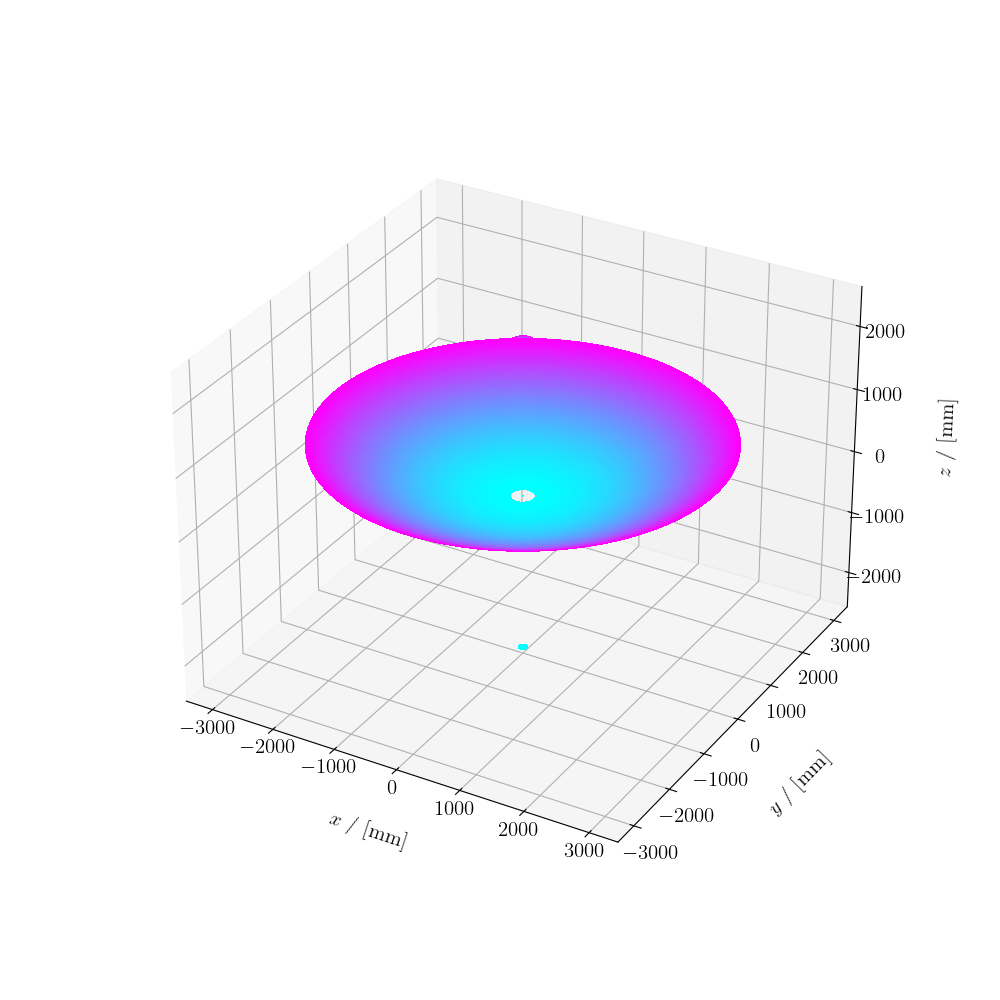

In [55]:
s.plotSystem()

# Set up the Physical Optics Calculations

We now setup the physical optics calculations through the system.

The `method` can be either `CPU` or `GPU` to choose between the C and CUDA implementations. This change also affects the
the floating point precision used in the calculations.

The `mode` for intermediate surfaces can be either `JMEH` or `JM`. In the `JMEH`, both the E & H fields and the J & M 
currents are calculated and stored on each surface.  In the `JM` mode, only the currents are stored. Choosing the `JM` mode
is somewhat faster, and uses less RAM.

In [60]:
method = 'GPU'
mode = 'JM'

In [61]:
# Physical optics calculation definition from feed to secondary
feed_to_sec_PO = {
        "t_name"    : "secondary",
        "s_current" : "gaussian_feed",
        "epsilon"   : 10,
        "mode"      : mode,
        "name_JM"   : "JM_sec",
        "name_EH"   : "EH_sec",
        "device"    : method
        }

# Physical optics calculation definition from secondary to primary
sec_to_pri_PO = {
        "t_name"    : "primary",
        "s_current" : "JM_sec",
        "epsilon"   : 10,
        "mode"      : mode,
        "name_JM"   : "JM_pri",
        "name_EH"   : "EH_pri",
        "device"    : method
        }

# Physical optics calculation definition from primary to far field
pri_to_ff_PO = {
        "t_name"    : "farfield_plane",
        "s_current" : "JM_pri",
        "epsilon"   : 10,
        "mode"      : "FF",
        "name_EH"   : "EH_ff",
        }

# Run the Physical Optics calculations

We run the full Physical Optics calculations, and collect some perfomance information on the way

In [ ]:
start = perf_counter()
step_times = []

s.runPO(feed_to_sec_PO)
step_times.append(perf_counter() - start)

s.runPO(sec_to_pri_PO)
step_times.append(perf_counter() - step_times[-1] - start)

s.runPO(pri_to_ff_PO)
step_times.append(perf_counter() - step_times[-1]- sstart )

2026-02-10 17:29:37 - WORK - *** Starting PO propagation *** 
2026-02-10 17:29:37 - WORK - Propagating gaussian_feed on feed_plane to secondary, propagation mode: JM. 
2026-02-10 17:29:37 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-10 17:29:37 - WORK - ... Calculating ... 
2026-02-10 17:29:42 - WORK - *** Finished: 5.734 seconds *** 
2026-02-10 17:29:42 - WORK - *** Starting PO propagation *** 
2026-02-10 17:29:42 - WORK - Propagating JM_sec on secondary to primary, propagation mode: JM. 
2026-02-10 17:29:42 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-10 17:29:42 - WORK - ... Calculating ... 
2026-02-10 17:40:14 - WORK - *** Finished: 631.735 seconds *** 
2026-02-10 17:40:14 - WORK - *** Starting PO propagation *** 
2026-02-10 17:40:14 - WORK - Propagating JM_pri on primary to farfield_plane, propagation mode: FF. 
2026-02-10 17:40:14 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-10 17:40:14 - WORK - ... Calculating ... 
2026-02

In [66]:
print(step_times)

[5.7501293000023, 25979.656988099996, 21.14466700000412]
